# Final Project

The final project is designed to let you apply what you have learned so far, and demonstrate that you have mastered it. The submission will be graded on the correctness and performance of the execution of your analysis (50%), the ambitiousness of the problems chosen (30%), and the creativity of your questions and solutions (20%).

Your submission should include all outputs and be *self-contained*, so it can be executed if necessary.

The submission includes two parts:
1. this notebook
2. a 15-min presentation, to be held on May 7


## Submission
The project is due on ***May 06, 23:59 CET*** (counted as the time stamp when it is received). Late submissions will **not** be considered, and graded as 0! 

To submit, please:

1. copy this file and all additional data into a folder with your group ID
3. zip the folder
4. send a copy of the zip file to Dirk Hovy <dirk.hovy@unibocconi.it> and Tommaso Fornaciari <fornaciari@unibocconi.it>

## 1. Research Question(s) (2 pts)

Describe what question you are investigating with the data (max. 100 words)

Starting from a dataset where the single documents are the last year linkedin posts of the S&P 500 companies, we aim at: -research question of classification.
Together with this, attaching a label to the companies based on their capitalization (more details later), we want to train a model that is able to capture how large a company is starting from its social communication strategy.

## 2. Data, Preprocessing, Annotation, and Analysis (6 pts)

Find a data set for **text classification** and a data set for **structured prediction**. These can be the same.
Kaggle is a good place to start, or the Google data set search. 

The data sets should have **at least 5,000** documents each. **At least 2000 instances** need to be labeled. 

If there is no label available, you can annotate your own and get up to **2 bonus points**, depending on the amount and complexity of the annotation.

Split each data set into dedicated training, development, and test sets (if they do not include these already)!

Briefly (max. 100 words!) describe the content and type of the data set, and what you are planning to look at. 

The initial dataset we scraped is composed by all the linkedin posts of the S&P 500 companies that have used some sort of communication on that social network in the period ranging from 18th April 2020 to 18th April 2021. In particular, it is characterized by 462 companies and 53938 rows, where each row is a document (namely, each post we scraped). Together with this, we decided to derive from Yahoo Finance the market capitalization of the firms, which we add as an extra column, in order to label them as 'large', 'medium' and 'small' size. This is particularly helpful for the last step of our analysis.

Preprocess the data and explain (max. 200 words) which preprocessing steps you chose and why, and give statistics of the number of documents, types, and tokens, before and after preprocessing.

...

In [1]:
import pandas as pd
import numpy as np

import nltk
import spacy
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.collocations import *

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import colors
import seaborn as sb
import matplotlib.cm as cm

from gensim.models import Word2Vec, Doc2Vec, TfidfModel, CoherenceModel, AuthorTopicModel
from gensim.models.word2vec import FAST_VERSION
from gensim.models.doc2vec import TaggedDocument
from gensim.corpora import Dictionary
from gensim.models.phrases import Phrases
from gensim.test.utils import datapath, temporary_file
from gensim.models import AuthorTopicModel

import time 
import multiprocessing
import string
import random
import re

nlp = spacy.load('en_core_web_sm')
stopwords = stopwords.words("english")

In [3]:
df = pd.read_excel('linkedin_posts.xlsx')

In [4]:
# Function to remove the web links and add a column called NoLink with no links

pattern=r'(?i)\b((?:[a-z][\w-]+:(?:/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))'

fin = []

for text in df['Post Text']:
    match = re.findall(pattern, text)
    for m in match:
        url = m[0]
        text = text.replace(url, '')
    fin.append(text)
    
df['No Link'] = fin

In [5]:
# Function to store hashtags and store them in a column called Hashtag

pattern = r"#(\w+)"

up = []

for text in df['Post Text']:
    match = re.findall(pattern, text)
    up.append(match)
    
df['Hashtag'] = up

In [6]:
# Function to remove all the non-alphanumeric characters and some other character

regex = re.compile('[^a-zA-Z0-9,\.!?\'\s]')

new = []

for text in df['No Link']:
    nuevo = regex.sub('', text)
    new.append(nuevo)
    
df['No Strange'] = new

In [7]:
# Make sure they are strings

documents = df['Post Text'].apply(str).tolist()                   
documents_tok = df['No Strange'].apply(str).tolist()

In [12]:
print('We have', len(documents_tok), 'documents')
len(documents_tok) == len(documents) 

#As expected, the two columns have the same dimension. In fact, at this stage no real preprocessing has been implemented.

We have 53938 documents


True

In [13]:
#This process will take around 6 minutes.
#We want to provide some statistics about the number of tokens in our dataframe which are Nouns, Verbs, Adjectives, Adverbs or proper nouns.

tokens = [token.text for sentence in documents_tok for token in nlp(sentence) if token.pos_ in ('NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN')]

In [21]:
#Lowercase all the tokens

tokenss = []
for i in tokens:
    tok = i.lower()
    tokenss.append(tok)

In [22]:
print('Length of tokens at this step:', len(tokenss))
print()
print(Counter(tokenss))

Length of tokens at this step: 1486684

Counter({'more': 19943, 'learn': 11569, 'how': 11366, 'new': 7909, 'here': 7034, 'team': 6218, 'help': 6086, 'work': 5470, 'today': 5406, 'year': 5251, 'business': 4830, 'read': 4768, 'be': 4713, 'world': 4470, 'join': 4433, 'support': 4086, 'women': 3971, 'employees': 3936, 'day': 3916, 'global': 3909, "'re": 3907, 'proud': 3749, 'people': 3679, 'health': 3661, 'now': 3478, 'have': 3421, 'company': 3381, 'community': 3285, 'technology': 3271, 'communities': 3258, 'covid19': 3247, 'time': 3222, 'future': 3125, 'make': 3077, 'customers': 2971, 'virtual': 2945, 'see': 2913, 'pandemic': 2902, 'energy': 2862, 'part': 2846, 'when': 2753, 'industry': 2748, 'data': 2650, 'working': 2594, 'solutions': 2587, 'first': 2577, 'program': 2547, 'president': 2490, 'ceo': 2484, 'career': 2438, 'care': 2388, 'experience': 2359, 'need': 2358, 'diversity': 2353, 'most': 2327, 'digital': 2272, 'best': 2255, 'years': 2200, 'find': 2177, 'get': 2163, 'together': 2162,

In [24]:
words_no_punc = []

#Removing punctuation marks:
for w in tokenss:
    if w.isalpha():
        words_no_punc.append(w.lower())

#Removing stopwords
clean_words = []

for w in words_no_punc:
    if w not in stopwords:
        clean_words.append(w)

In [25]:
print('The length of tokens is now:', len(clean_words))

#Almost half of the previous length, after removing stopwords and puctuation marks.

The length of tokens is now: 1368308


In [26]:
#However, we are not interested in words with less than 3 characters

words = [x for x in clean_words if len(x) > 3]

print('The length of tokens is now:', len(words))

The length of tokens is now: 1286740


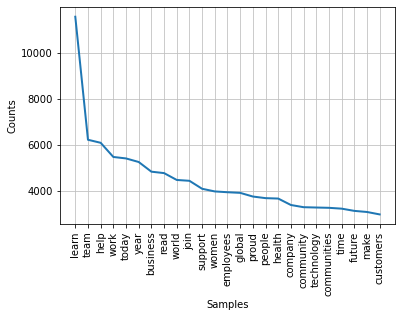

In [27]:
#Frequency distribution of the 25 most common useful words:
fdist = FreqDist(words)
fdist.plot(25)

#What can be noted here is that, even after the preprocessing steps, the distribution of words resembles a Zipf's one.

Provide some basic analysis of the training data with any of the following analysis methods (justify your choices):

1. Topic modeling with LDA. Justify your choice of number of topics!
2. Word embeddings 
3. Document embeddings: visualize these and show a clustering

We propose an **author topic model** as part of our pre-analysis step in order to determine whether we can see differences within the communication of companies belonging to different sectors. In particular, we collect all the relevant preprocessing steps in a function ('clean') and starting from it we add another column to our dataframe.

In [49]:
def clean(text):
    return ' '.join([token.lemma_  #Lemmatization
            for token in nlp(text)
            if (token.pos_ in {'NOUN', 'ADJ', 'ADV', 'VERB'}) & #We don't want all the POS
             (token.lemma_ not in stopwords) &       
             (len(token)>3) &     #We don't want too short words
             (token.lemma_ not in {'more', 'here', 'join', 'click', 'work', 'learn', 'year', 'tell',
                                  'multifamilyrealestate', 'propertymanagement', 'apply', 'livestock',
                                  'help', 'make', 'today', 'read'})]) 

#As you may note, some lemmas were excluded manually, after some trials, in order to get meaningful clusters.
#In fact, some words are extensively employed 

In [50]:
df['Text Cleaned'] = df['No Strange'].apply(clean)  #Adding a column, cleaned, to our df

In [51]:
author2doc = defaultdict(list)
target_category = 'Sector' 
#limit=45000 

for i, Sector in enumerate(df[target_category]):
    author2doc[Sector].append(i)

In [52]:
instances = df['Text Cleaned'].apply(str.split).tolist()
print("Working on creating dictionary, I am fast, keep calm man", flush=True)

phrases = Phrases(instances, min_count=1, threshold=1)
instances_colloc = phrases[instances]

dictionary = Dictionary(instances_colloc)

dictionary.filter_extremes(no_below=1, no_above=0.3) #get rid of some words
print(dictionary, flush=True)

Working on creating dictionary, I am fast, keep calm man
Dictionary(100000 unique tokens: ['daughter', 'father', 'front_line', 'get', 'hospital']...)


In [53]:
print("Translating corpus to IDs, no rush please", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]

tfidfmodel = TfidfModel(ldacorpus)

model_corpus = tfidfmodel[ldacorpus]

Translating corpus to IDs, no rush please


In [54]:
#To find the best number of topics, I run a CoherenceModel with different evaluation scores on a subset of the data.
#Please note that it takes between X and Y minutes (depending on the range), say 30 sec for every value in the range

coherence_values = []
author_model_list = []

dev_size = 22000

dev_author2doc = {key: [idx for idx in value if idx < dev_size] for key, value in author2doc.items()}

for num_topics in range(3, 10):
    author_model = AuthorTopicModel(corpus=list(ldacorpus[:dev_size]),  author2doc=dev_author2doc, 
                                    id2word=dictionary, num_topics=num_topics,
                                    alpha=0.6, #the result of some trials
                                    random_state=42) #as I did from the beginning)
    
    coherencemodel_umass = CoherenceModel(model=author_model, 
                                          texts=instances[:dev_size], 
                                          dictionary=dictionary, 
                                          coherence='u_mass')

    coherencemodel_cv = CoherenceModel(model=author_model, 
                                       texts=instances[:dev_size], 
                                       dictionary=dictionary, 
                                       coherence='c_v')

    umass_score = coherencemodel_umass.get_coherence()
    cv_score = coherencemodel_cv.get_coherence()
    
    print(num_topics, umass_score, cv_score)
    coherence_values.append((num_topics, umass_score, cv_score))

3 -9.061892039619464 0.38152292074376853
4 -10.715358398052665 0.4451138120168752
5 -10.35499447080947 0.4348486585134098
6 -10.996055794859721 0.48058290459008585
7 -12.818988493366236 0.5171417692388834
8 -11.751992736228775 0.5019811352716104
9 -12.150238257494102 0.5142118575652526


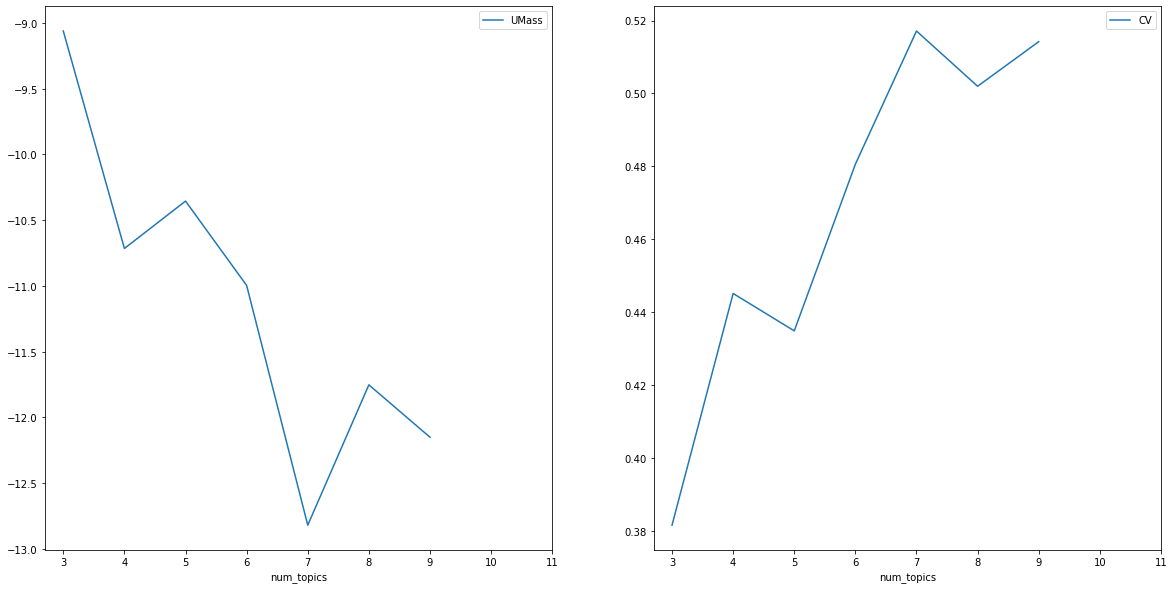

In [55]:
%matplotlib inline
scores = pd.DataFrame(coherence_values, columns=['num_topics', 'UMass', 'CV'])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
scores.plot.line(x='num_topics', y='UMass', ax=ax[0], xticks=range(3,12));
scores.plot.line(x='num_topics', y='CV', ax=ax[1], xticks=range(3,12));

In [56]:
#Ci mette circa 4 min

n_topics_author = 8

#I find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)

author_model = AuthorTopicModel(corpus=list(ldacorpus), author2doc=author2doc, id2word=dictionary, num_topics=n_topics_author,
                                passes=num_passes, chunksize=chunk_size, alpha=0.6, random_state=42)
                                #parameter consistency

2696.9


In [57]:
topic_sep = re.compile("0\.[0-9]{3}\*") #Getting rid of useless formatting, in case it is needed (even if the df column is already cleaned)

author_model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                author_model.print_topics(num_topics=n_topics_author, num_words=5)]


author_descriptors = []
for i, m in sorted(author_model_topics):
    print(i+1, ", ".join(m[:5]))
    author_descriptors.append(", ".join(m[:2]).replace('"', ''))

1 "farming", "ship", "fashion", "shipment", "shout"
2 "food", "fresh", "insecurity", "cold", "delicious"
3 "animal", "health", "care", "veterinary", "disease"
4 "dog", "thevulcanway", "vulcanmaterialscompany", "construction", "hybrid"
5 "energy", "water", "storage", "power", "technology"
6 "nutrition", "hundred", "surveillance", "geography", "scenario"
7 "technology", "late", "business", "insight", "solution"
8 "team", "community", "support", "share", "company"


In [58]:
df['Sector'].unique()

array(['Industrials', 'Health_Care', 'Information_Technology',
       'Consumer_Discretionary', 'Utilities', 'Financials', 'Materials',
       'Real_Estate', 'Consumer_Staples', 'Energy',
       'Telecommunication_Services'], dtype=object)

In [59]:
author_vecs = {author: {author_descriptors[t]: 0.0
                         for t in range(author_model.num_topics)}
              for author in author_model.id2author.values()}

for author in author_model.id2author.values():
    for (t, v) in author_model.get_author_topics(author):
        author_vecs[author][author_descriptors[t]] = v

        
target_sectors = 'Industrials Health_Care Information_Technology Consumer_Discretionary Utilities Financials Materials Real_Estate Consumer_Staples Energy Telecommunication_Services'.split()
for sector in target_sectors:
    print(sector, author_vecs[sector])

Industrials {'farming, ship': 0.032068958080843125, 'food, fresh': 0.0, 'animal, health': 0.1090735134168305, 'dog, thevulcanway': 0.0, 'energy, water': 0.2848889615165301, 'nutrition, hundred': 0.0, 'technology, late': 0.11072872231984313, 'team, community': 0.4623006148275338}
Health_Care {'farming, ship': 0.0, 'food, fresh': 0.0106000885322978, 'animal, health': 0.647412928912726, 'dog, thevulcanway': 0.0, 'energy, water': 0.0, 'nutrition, hundred': 0.0, 'technology, late': 0.14571454012362858, 'team, community': 0.18150297765901752}
Information_Technology {'farming, ship': 0.0, 'food, fresh': 0.0, 'animal, health': 0.12972343933630973, 'dog, thevulcanway': 0.012081125487315773, 'energy, water': 0.1392281090019703, 'nutrition, hundred': 0.0, 'technology, late': 0.147684074933754, 'team, community': 0.5598615115412097}
Consumer_Discretionary {'farming, ship': 0.0, 'food, fresh': 0.09941098059713248, 'animal, health': 0.15655631137573264, 'dog, thevulcanway': 0.0, 'energy, water': 0.0

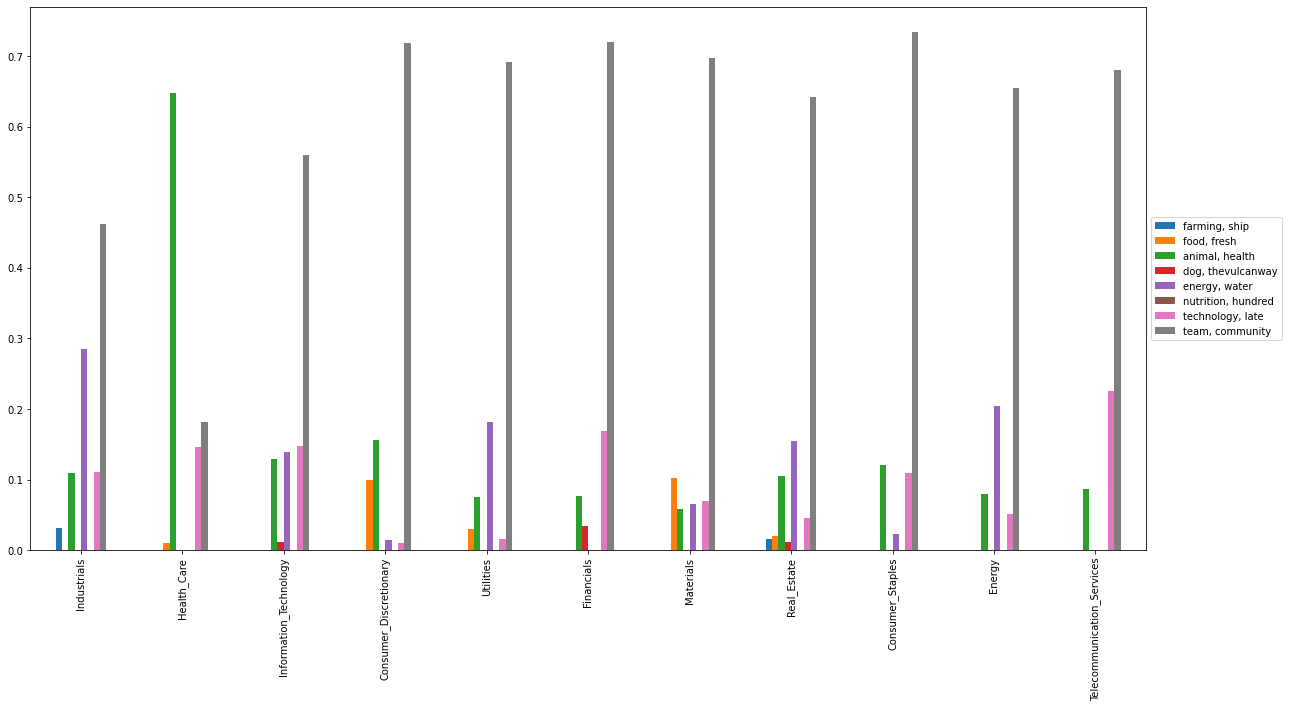

In [60]:
author_df = pd.DataFrame.from_dict(author_vecs)

fig, ax = plt.subplots(figsize=(20,10))
author_df[target_sectors].T.plot.bar(ax=ax)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5));

COMMENTO DA CAMBIARE IL BASE AL GRAFICO FINALE

Generally speaking we start seeing some interesting elements. As expected, different sectors appear to have some common elements but also some distinctive features. \
In particular, we see a prevalence of the blue column across all sectors. This appears to make sense in that the first topic includes words such as "team" and "community" which are common in all fields. The extra height in the Financials sector is probably driven by "share", which as we know, especially for that sector, may also assume another meaning. \
The orange column mainly characterizes the Healthcare industry. Within the 5 words, 4 are very typical of that sector, plus the 5th ("Zoetis"), results to be one of the major players. \
The customer centricity which is the major driver of the third topic is particularly relevant in the two 'consumer'-labeled sectors. \
"Safety" is evidently the key element on which the height of the red column base its pillars. In fact, both in the 'utilities' and in the 'energy' sector, clients consider it to be the main indicator for their choices. We also see an increasing interest for this aspect in the IT word.  \
Topic 5 is evidently related to materials; "packaging" leads the way in driving the column behaviour. \
The 6th topic has a difficult interpretation for our previous knowledge. Still, it appears to be mostly connected with the Consumer staples and industrial sectors. \
The last two topics are very interesting to look at. In fact, they evidence how, even if both characterized by the words "technology" and "solution", the other three elements of the topic play a major role. \
The 7th column is higher in telco, Healthcare and Consumer staples while the last one is dominant again in Telco but also, as expected, in IT. The main difference is probably due to the contrast between "business", which is more consumer oriented, and "design" which instead refers to specific elements of the operation services of the firms characterizing IT and Telco industries.

## 4. Prediction (17 pts)


### 4.1 Classification (9 pts)
Build a predictive model of the target label and use appropriate performance metrics. Your predictive analysis needs to involve **all** of the following, summarized in a table:

1. a most-frequent-label baseline (1 pt)
2. a `LogisticRegression()` baseline with default parameters and 2-6 gram character TFIDF features (1 pt)
3. **at least** two more predictive models, including description/justification of the optmization steps taken (6 pts).
4. bootstrap sampling significance tests of the performance difference between your best model and each of the two baselines (1 pts)

NB: Do make sure that the optimization steps are done on the development split and do *not* include the test split! Training on the test set will be graded 0!


### 4.1 Structured Prediction (8pts)
Adapt the Structured Perceptron to your sequence prediction task, and note the performance as baseline (3 pt).
Implement a suitable neural net architecture (in `keras`) on the data (4 pts). Compare the best performance of the  models (1 pt).

In [1]:
# your code here

## 3. Visualizations (5 pts)

Provide at least 3 visualizations of your work above. These can be in the respective sections. Use labels and legends. Be creative. Just please do not use word clouds...

In [1]:
# your code here